# Activity Detection using IMU Dataset

In [1]:
import pandas as pd
import numpy as np
import json
import peakutils
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import seaborn as sns

/Users/yuxiwu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/yuxiwu/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/yuxiwu/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0

### Importing helper functions to process the IMU data
We just need to run master() once to have a nice dataframe of all the acclerometer data and related generated features.

In [2]:
%run cleaner.py
master = master()
master.head(10)

,activity,x_accl_mean,x_accl_peaks,x_accl_sd,y_accl_mean,y_accl_peaks,y_accl_sd,z_accl_mean,z_accl_peaks,z_accl_sd,activity_factor
0,Driving,-52.752747,491,83.277791,1.607692,492,129.572047,1367.235165,452,225.292261,0
1,Driving,-50.645733,495,92.015000,8.815352,487,114.683266,1372.819109,466,196.675695,0
2,Driving,-80.717705,1039,45.667297,13.767745,874,58.820492,1331.725320,1025,82.708072,0
3,Driving,-81.664960,1023,47.322432,12.431806,879,66.012635,1329.912129,1017,87.806420,0
4,Driving,-50.220434,866,88.336456,14.713535,882,119.871838,1364.935611,773,243.216303,0
5,Driving,-50.490665,882,88.059353,11.094333,900,123.345362,1360.848018,806,221.054725,0
6,Driving,-47.604014,819,111.691160,7.774132,816,111.930767,1365.392482,774,213.819213,0
7,Driving,-54.362620,320,107.143932,-13.051118,318,117.552920,1365.596645,317,182.419901,0
8,Driving,-51.880914,667,84.065410,-24.252039,678,125.676746,1365.621533,618,235.589804,0
9,Driving,-51.664802,682,93.554972,10.716740,685,118.448348,1368.781862,621,237.052025,0


### Creating splits for training and test
We train with 67% of the data and test on 33%.

In [3]:
X_train, X_test, y_train, y_test = splits(master, 0.33)

### Selecting hyperparameters for the linear SVM model and initialising the validation curve

In [4]:
C_params = np.logspace(-6, 3, 10)
svc_2 = LinearSVC(random_state = 1234)

train_scores, test_scores = validation_curve(
    svc_2, X_train.values, y_train.values.flatten(),
    param_name="C", param_range=C_params,
    cv=2, scoring="accuracy", n_jobs=-1)

In [5]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

### Plotting the validation curve

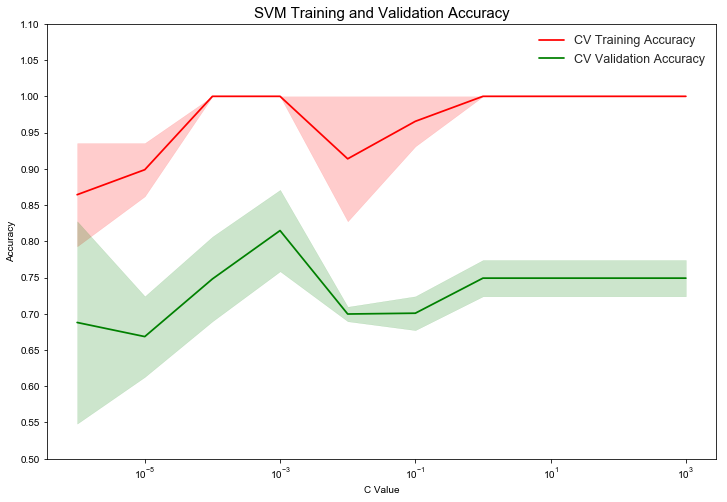

In [6]:
y_min = 0.5
y_max = 1.1

f = plt.figure(figsize = (12, 8))
ax = plt.axes()
sns.set(font_scale = 1.25)
sns.set_style("darkgrid")
plt.title("SVM Training and Validation Accuracy")
plt.xlabel("C Value")
plt.ylabel("Accuracy")
plt.ylim(y_min, y_max)
plt.yticks(np.arange(y_min, y_max + .01, .05))
plt.semilogx(C_params, train_scores_mean, label="CV Training Accuracy", color="red")
plt.fill_between(C_params, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="red")
plt.semilogx(C_params, test_scores_mean, label="CV Validation Accuracy",
             color="green")
plt.fill_between(C_params, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="green")
plt.legend(loc="best")
plt.show()

### Training the grid search model
We use rbf and linear kernel classification and output our model’s accuracy score and baseline accuracy for reference.

In [7]:
# train gridsearch model
# using rbf and linear kernel
Cs = np.logspace(-6, 3, 10)
parameters = [{'kernel': ['rbf'], 'C': Cs},
              {'kernel': ['linear'], 'C': Cs}]

svc = SVC(random_state = 1234)

clf = GridSearchCV(estimator = svc, param_grid = parameters, cv = 2, n_jobs = -1)
clf.fit(X_train.values, y_train.values)

GridSearchCV(cv=2, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1234, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'kernel': ['rbf'], 'C': array([  1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03])}, {'kernel': ['linear'], 'C': array([  1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03])}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

### Best estimator and best parameters

In [8]:
print(clf.best_estimator_)
print(clf.best_params_)

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=1234, shrinking=True,
  tol=0.001, verbose=False)
{'C': 0.001, 'kernel': 'linear'}


### Accuracy score for the best estimator model

In [9]:
clf.score(X_test, y_test)

0.96666666666666667

### Baseline accuracy
This is the accuracy score we would get if we had no features in the model.

In [10]:
y_test.value_counts().values[0] / y_test.value_counts().values.sum()

0.29999999999999999

### Creating a dataframe of activity labels

In [11]:
label_desc_df = pd.DataFrame(master.activity.unique().tolist(), columns = ['activity'])
label_num_df = pd.DataFrame(master.activity_factor.unique().tolist(), columns = ['activity_factor'])
activity_df = pd.concat([label_num_df, label_desc_df], axis=1)

### Crosstab for displaying model evaluation

In [12]:
crosstab = pd.crosstab(y_test.values.flatten(), clf.predict(X_test),
                          rownames=['True'], colnames=['Predicted'],
                          margins=True)
crosstab

Predicted,0,1,2,3,All
True,,,,,
0,5,0,0,0,5
1,0,8,0,0,8
2,0,1,8,0,9
3,0,0,0,8,8
All,5,9,8,8,30


### Labeled version of crosstab

In [13]:
crosstab_clean = crosstab.iloc[:-1, :-1]
crosstab_clean.columns = activity_df.activity.values
crosstab_clean.index = activity_df.activity_factor.values
crosstab_clean

,Driving,Standing,Walking,Jumping
0,5,0,0,0
1,0,8,0,0
2,0,1,8,0
3,0,0,0,8
